In [1]:
%pip install sklearn
%pip install scikit-learn
%pip install matplotlib
%pip install Wordcloud

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
    

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import json
from data_exploration_functions import *
from main import count_occurrences

# IN DOMAIN EXPERIMENTS

## ENGLISH

### Dataset analysis

The in-domain dataset we have chosen for English is the ParTUT dataset from Universal dependencies (https://universaldependencies.org/), available in [github](https://github.com/UniversalDependencies/UD_English-ParTUT/tree/master). This dataset is composed of a variety of legal texts, talks and wikipedia articles, among others.

The dataset is divided into training, development and test sets. The division is the following:

- en_partut-ud-train.conllu: 43518 words (1781 sentences)
- en_partut-ud-dev.conllu: 2722 words (156 sentences)
- en_partut-ud-test.conllu: 3408 words (153 sentences)

In [3]:
dataset_path = "UD-Data/English/"

info_train, i = conllu_dict(f'{dataset_path}/en_partut-ud-train.conllu')
info_dev, i = conllu_dict(f'{dataset_path}/en_partut-ud-dev.conllu', i+1)
info_test, i = conllu_dict(f'{dataset_path}/en_partut-ud-test.conllu', i+1)
all_info = {**info_train, **info_dev, **info_test}

In [4]:
train_words = 0
dev_words = 0
test_words = 0
train_lengths = []
dev_lengths = []
test_lengths = []

for doc in info_train.values():
    if isinstance(doc, dict):
        train_lengths.append(len(doc['sentence']))
        train_words += len(doc['sentence'])
for doc in info_dev.values():
    if isinstance(doc, dict):
        dev_lengths.append(len(doc['sentence']))
        dev_words += len(doc['sentence'])
for doc in info_test.values():
    if isinstance(doc, dict):
        test_lengths.append(len(doc['sentence']))
        test_words += len(doc['sentence'])

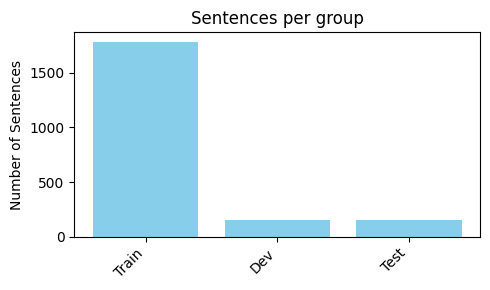

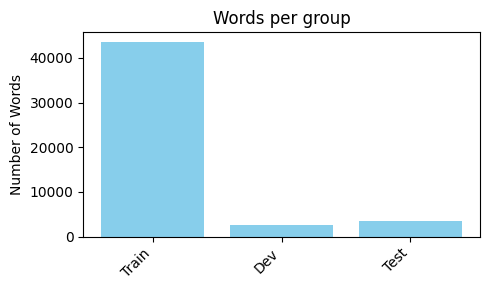

In [5]:
counts_for_files(['Train', 'Dev', 'Test'], [len(info_train)-1, len(info_dev)-1, len(info_test)-1])
counts_for_files(['Train', 'Dev', 'Test'], [train_words, dev_words, test_words], "Words")

The sentence length distribution is shown in the following boxplot. The distribution is similar for the three sets, with the dev set having a slightly lower average length. Overall, the sentences are between 0 and 50 words, and the average length is around 20 words. The train set has the longest sentences, with many outliers above 50 words, reaching up to 100 words. This is expected as the data is composed of legal text and articles from wikipedia, which are overall formal texts with long sentences. Also, all the outliers are in the train set, so the model is more robust to long sentences because they are well represented in the train set.

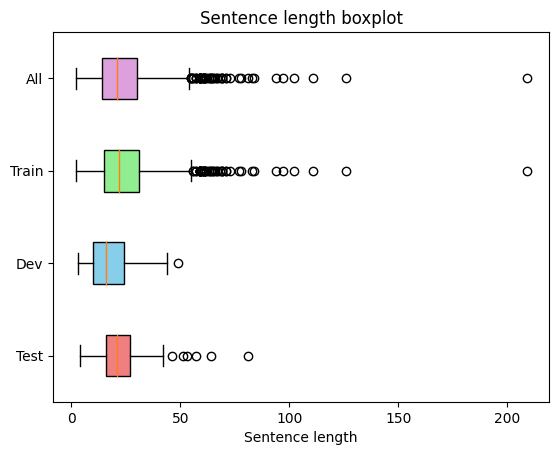

In [6]:
sentence_length_boxplot(['Test', 'Dev', 'Train', 'All'], [test_lengths, dev_lengths, train_lengths, train_lengths+dev_lengths+test_lengths])

In [7]:
counts_trains = count_occurrences('UD-Data/', ['train'], write=False)
counts_dev = count_occurrences('UD-Data/', ['dev'], write=False)
counts_test = count_occurrences('UD-Data/', ['test'], write=False)
total_counts = count_occurrences('UD-Data/', ['train', 'dev', 'test'], write=False)

3648
18552
857
6166
777
6318
3648
857
777
18552
6166
6318


The next matrix shows the number of transitions between tags in the train set. The matrix shows that the most common transitions are between tags like DET and NOUN, NOUN and PUNCT, and NOUN and ADP.

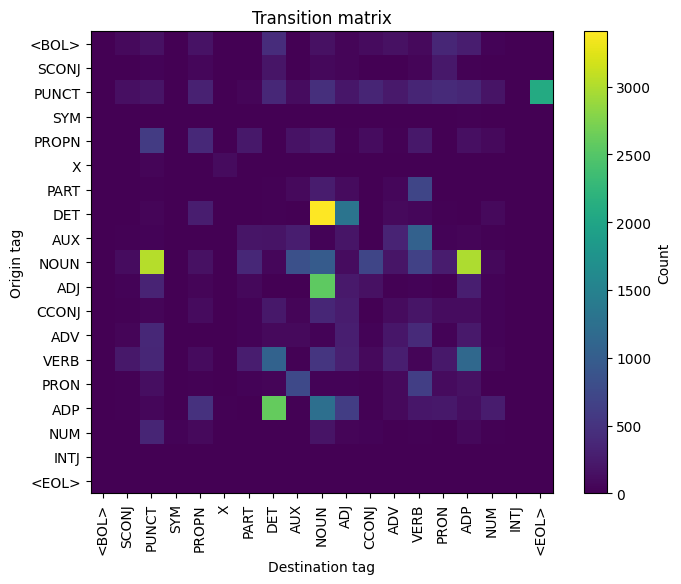

In [8]:
transitions = total_counts['English']['transitions']
transition_matrix(transitions)

In the next plot we can see the tag frequencies from all the sets, shown in logarithmic scale. The NOUN is the most common tag in all the sets and the less frequent tag is INTJ. However, the other tags are quiet similar, so we can say that the datasets are balanced.

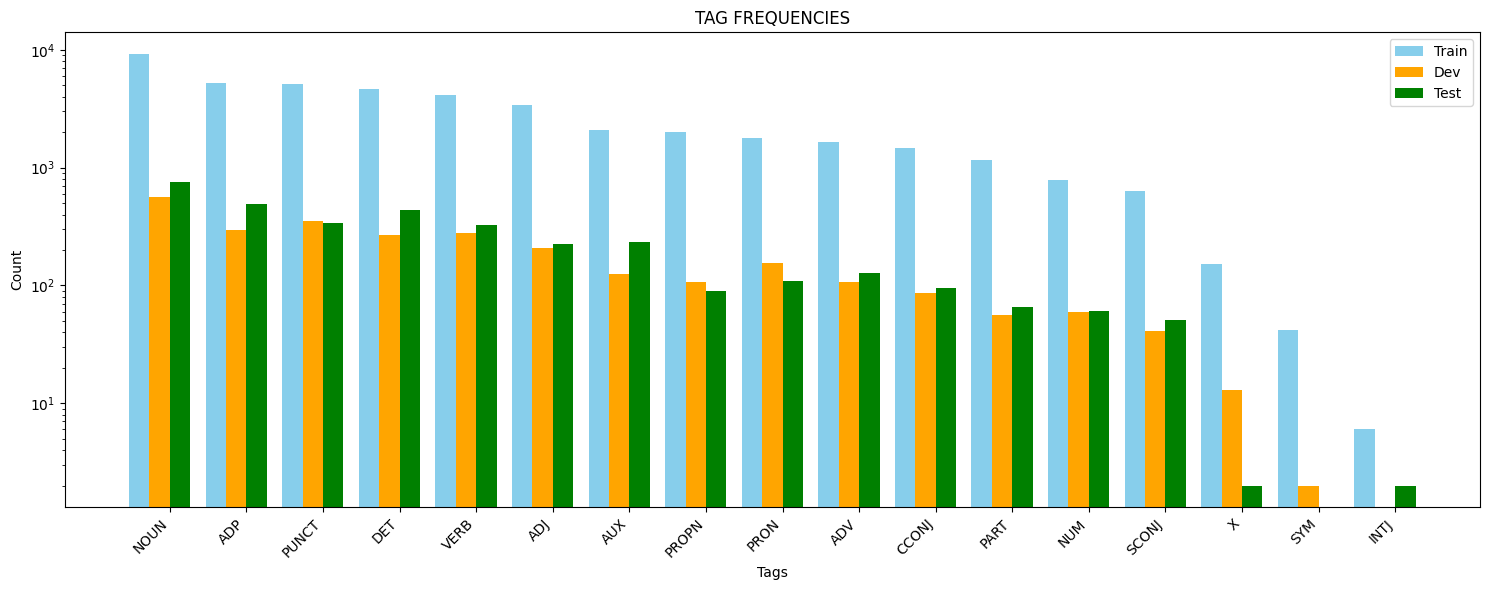

In [9]:
data = {'train' : counts_trains['English']['tags'],
        'dev' : counts_dev['English']['tags'],
        'test' : counts_test['English']['tags']}
plot_subsets_comparison(data, "TAG FREQUENCIES")

**Unknown words analysis**

In the training set, we mark as unknown words those words that appear less than 2 times. The next plot shows the pos tags of the unknown words in the train set. The most common unknown words are tagged as NOUN, which is the most common tag in the train set. This is expected, as the nouns are the most probable words to appear only once or twice in the dataset, and also because the nouns are the most common words in the dataset.

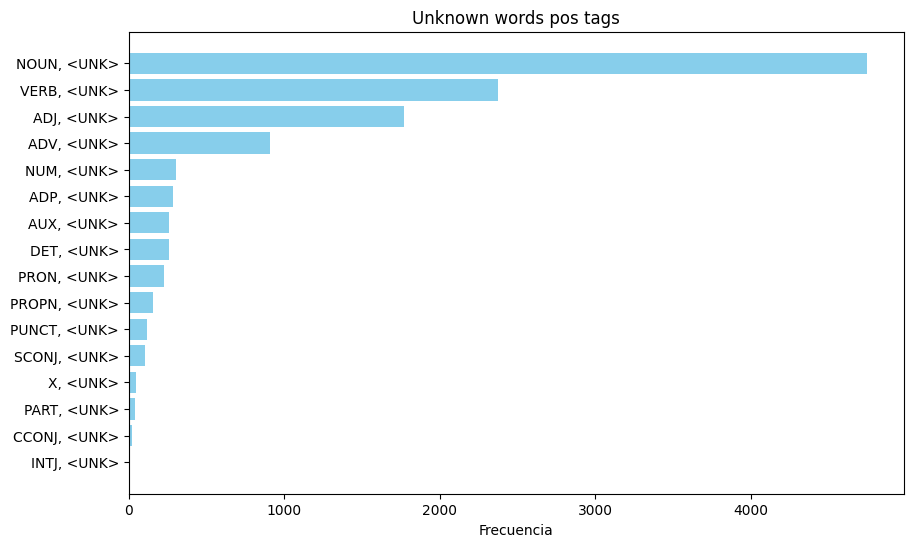

In [10]:
plot_pos_with_unknown(total_counts, "Unknown words pos tags")

### Results analysis


We train the model with the train and dev set. We get the predictions made by the model for the test in English language, and then we use the predictions together with the gold standar to get the accuracy.

In [10]:
lang = "English"
ruta_archivo = f"output/test_{lang}_predictions.jsonl"

all_tags, all_predictions, errors = get_tags_predictions(ruta_archivo)

**Accuracy score of the English model**

In [11]:
accuracy = accuracy_score(all_tags, all_predictions)
accuracy

0.8717723004694836

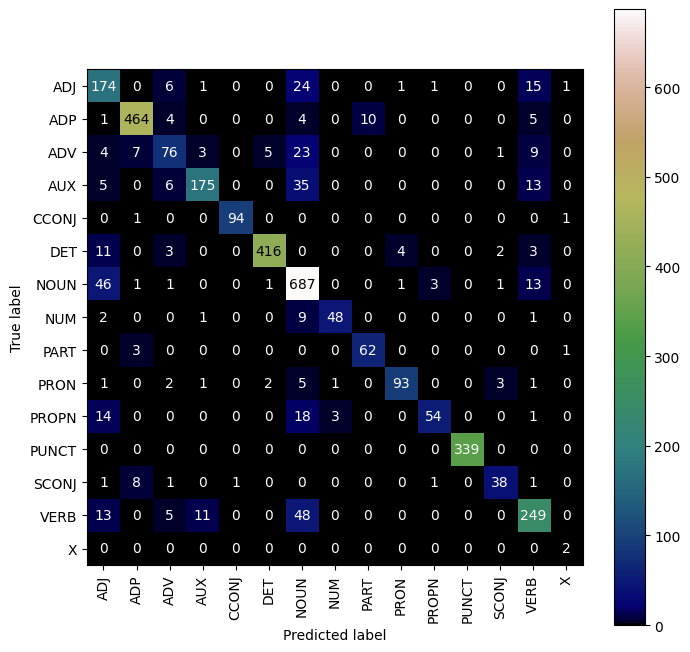

In [12]:
#create the confusion matrix
tags_set = sorted(set(all_predictions))
cm=confusion_matrix(all_tags, all_predictions, labels=tags_set)
cm

#show the plot
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust width and height as needed
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tags_set)
disp.plot(cmap="gist_earth", ax=ax, xticks_rotation="vertical")

plt.show()

The confusion matrix shows that there is high correlation between the actual tags and the model's predictions. Overall, the number of errors is low in all tags and the accuracy score is high (0.87). However, the model makes some errors for the NOUN tag. This tag is the most common one in the train set, so it is normal that the model tends to tag as NOUN the new words, and that could explain the errors. The NOUN is confused with the tag VERB 48 times

**FREQUENT INCORRECT WORDS ANALYSIS**

(Real Tag, Predicted Tag) [words frequency]

In [6]:
from collections import Counter
#print each type
#ADJ
for check_tag in ["ADJ", "NOUN", "VERB"]:
    print(f"-------{check_tag}--------")
    for tags,value in errors.items():
        if tags.split(",")[1] == check_tag:
            # Contar la cantidad de repeticiones de cada palabra
            word_counts = Counter(value)

            # Filtrar las palabras que aparecen más de una vez
            filtered_word_counts = {word: count for word, count in word_counts.items() if count > 1}

            # Ordenar las palabras por su frecuencia de mayor a menor
            sorted_filtered_word_counts = sorted(filtered_word_counts.items(), key=lambda x: x[1], reverse=True)
            if sorted_filtered_word_counts:
                print(tags, sorted_filtered_word_counts)
                print()

-------ADJ--------
NOUN,ADJ [('minimum', 2)]

PROPN,ADJ [('European', 3), ('General', 3)]

ADV,ADJ [('more', 2)]

-------NOUN--------
ADV,NOUN [('part', 3)]

ADJ,NOUN [('necessary', 2), ('base', 2)]

AUX,NOUN [('shall', 4)]

DET,NOUN [('Such', 2)]

-------VERB--------
AUX,VERB [('is', 3)]



In this analysis, we focus on the most common misclassified tags (ADJ, NOUN, and VERB) to identify patterns in the errors and the specific words involved. While the model achieves a high number of correct predictions overall, examining these errors can help uncover systematic issues and areas for improvement.

The adjective (ADJ) tag is frequently confused with other categories such as nouns (NOUN), proper nouns (PROPN), and adverbs (ADV). For example, minimum is often misclassified as a noun, likely due to its common use as a noun in specific contexts. Similarly, words like European and General are misclassified as proper nouns, which is understandable as these words can serve both as adjectives and as part of proper nouns, depending on usage. Additionally, more is often misclassified as an adverb instead of an adjective, reflecting the dual nature of this word in English grammar. These errors indicate that the model has difficulties with context-sensitive distinctions for adjectives.

Nouns (NOUN) exhibit significant errors, often being confused with adverbs (ADV), adjectives (ADJ), auxiliary verbs (AUX), and determiners (DET). Words like necessary and base are tagged as adjectives instead of nouns, likely because these words are more commonly used as adjectives. In addition, the word "base" only appears as NOUN and none as an ADJ in the whole train data. Moreover, "shall" is incorrectly labeled as a noun instead of its actual auxiliary function, and this is because "shall" is not in the train dataset, so it put the tag of the most frequent tag that is NOUN, because of the <UNK> token. Lastly, "such" is not in the train dataset neither.

In conclusion, these errors often stem from the dual functionality of words or from limited coverage in the training data for specific cases. These issues point to systematic gaps in its handling of ambiguous or low-frequency words. To improve the model's performance, we can try to augment the training data with more diverse examples of ambiguous and low-frequency words. Balancing class distributions ensures fairer representation of underrepresented tags, avoiding dominance by frequent ones like NOUN.

### EXPERIMENT WITH THE LEMMAS

0.8890845070422535


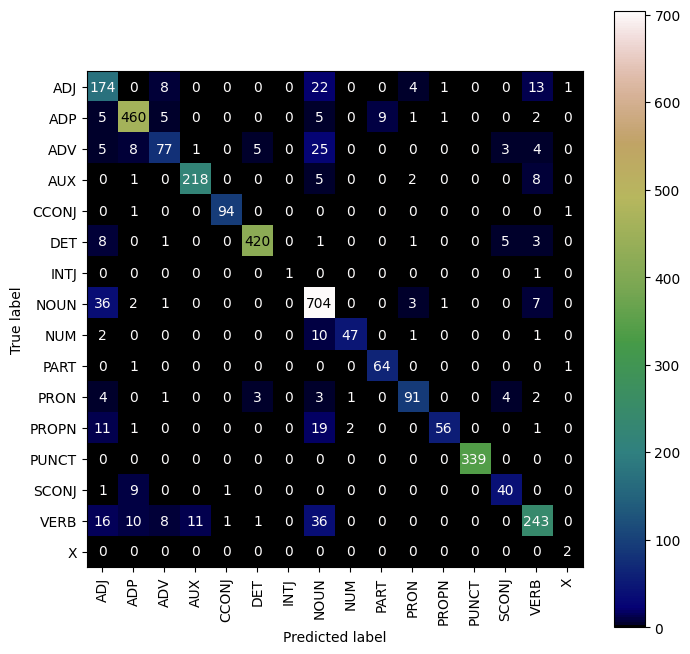

In [20]:
lang = "English"
ruta_archivo = f"output/test_{lang}_predictions.jsonl"

all_tags, all_predictions, errors = get_tags_predictions(ruta_archivo)

accuracy = accuracy_score(all_tags, all_predictions)
print(accuracy)

#create the confusion matrix
tags_set = sorted(set(all_predictions))
cm=confusion_matrix(all_tags, all_predictions, labels=tags_set)
cm

#show the plot
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust width and height as needed
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tags_set)
disp.plot(cmap="gist_earth", ax=ax, xticks_rotation="vertical")

plt.show()

After rerunning the train using lemmas instead of surface forms, the accuracy of the model improved slightly, increasing by 0.01. This minor improvement indicates that lemmatization helps the model generalize better by reducing the variability caused by different word inflections. While the change is small, it suggests that lemmatization can contribute to more precise tag predictions in certain contexts.

## SPANISH

### Dataset analysis

The in-domain dataset we have chosen for Spanish is the AnCora dataset from Universal dependencies (https://universaldependencies.org/), available in [github](https://github.com/UniversalDependencies/UD_Spanish-AnCora). This dataset is composed of news.

The dataset is divided into training, development and test sets. The division is the following:

- es_ancora-ud-train.conllu: 453039 words (442892 sentences)
- es_ancora-ud-dev.conllu: 53476 words (52212 sentences)
- es_ancora-ud-test.conllu: 53622 words (52454 sentences)

In [9]:
dataset_path = "UD-Data/Spanish/"

info_train, i = conllu_dict(f'{dataset_path}/es_ancora-ud-train.conllu')
info_dev, i = conllu_dict(f'{dataset_path}/es_ancora-ud-dev.conllu', i+1)
info_test, i = conllu_dict(f'{dataset_path}/es_ancora-ud-test.conllu', i+1)
all_info = {**info_train, **info_dev, **info_test}

In [10]:
train_words = 0
dev_words = 0
test_words = 0
train_lengths = []
dev_lengths = []
test_lengths = []

for doc in info_train.values():
    if isinstance(doc, dict):
        train_lengths.append(len(doc['sentence']))
        train_words += len(doc['sentence'])
for doc in info_dev.values():
    if isinstance(doc, dict):
        dev_lengths.append(len(doc['sentence']))
        dev_words += len(doc['sentence'])
for doc in info_test.values():
    if isinstance(doc, dict):
        test_lengths.append(len(doc['sentence']))
        test_words += len(doc['sentence'])

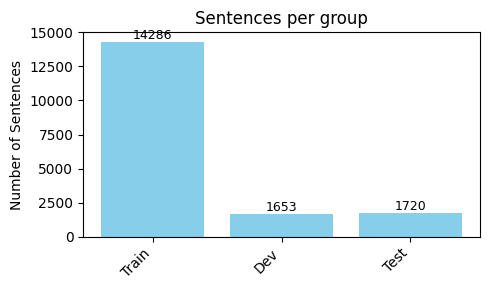

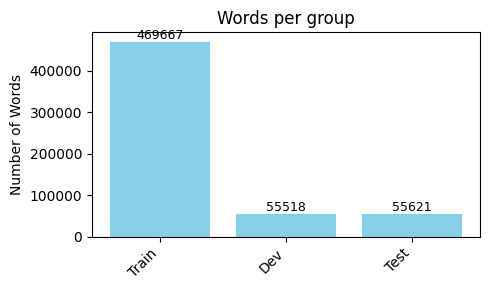

In [11]:
counts_for_files(['Train', 'Dev', 'Test'], [len(info_train)-1, len(info_dev)-1, len(info_test)-1])
counts_for_files(['Train', 'Dev', 'Test'], [train_words, dev_words, test_words], "Words")

In the next graphic we can the sentence length boxplot. The three sets are very similar as it can be seen, where the mean is at around 30 words/sentence. As it is a dataset about news, it is normal that the sentences are long, they are from 0 to 80 words/sentence. In addition, there are some outliers with 150 words/sentence.

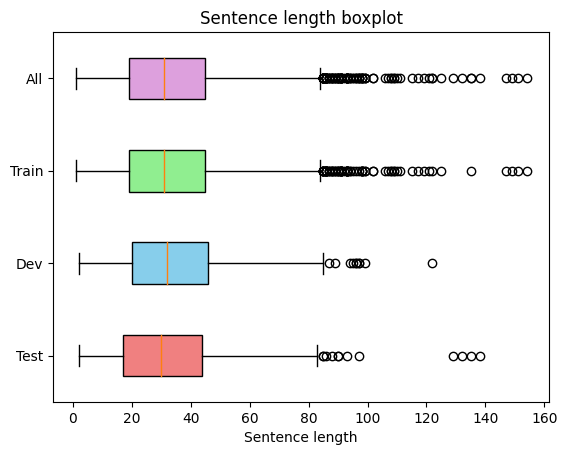

In [12]:
sentence_length_boxplot(['Test', 'Dev', 'Train', 'All'], [test_lengths, dev_lengths, train_lengths, train_lengths+dev_lengths+test_lengths])

In [13]:
counts_trains = count_occurrences('UD-Data/', ['train'], write=False)
counts_dev = count_occurrences('UD-Data/', ['dev'], write=False)
counts_test = count_occurrences('UD-Data/', ['test'], write=False)
total_counts = count_occurrences('UD-Data/', ['train', 'dev', 'test'], write=False)

3648
18552
857
6166
777
6318
3648
857
777
18552
6166
6318


The next matrix shows the number of transitions between tags in the train set. The matrix shows that the most common transitions are between tags like (ADP, DET), (NOUN, ADP) and (DET, NOUN).

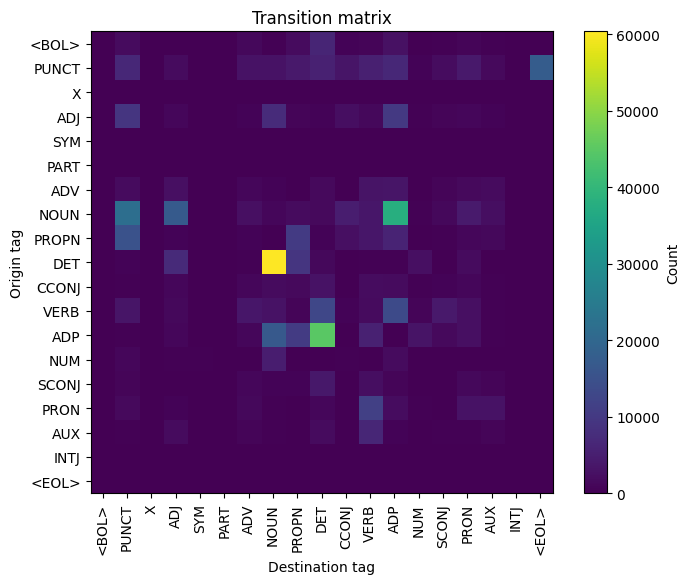

In [17]:
transitions = total_counts['Spanish']['transitions']
transition_matrix(transitions)

In the next plot we can see the tag frequencies from all the sets, shown in logarithmic scale. The NOUN is the most common tag in all the sets and the less frequent tags are PART and X. However, the other tags are quite similar, so we can say that the datasets are balanced.

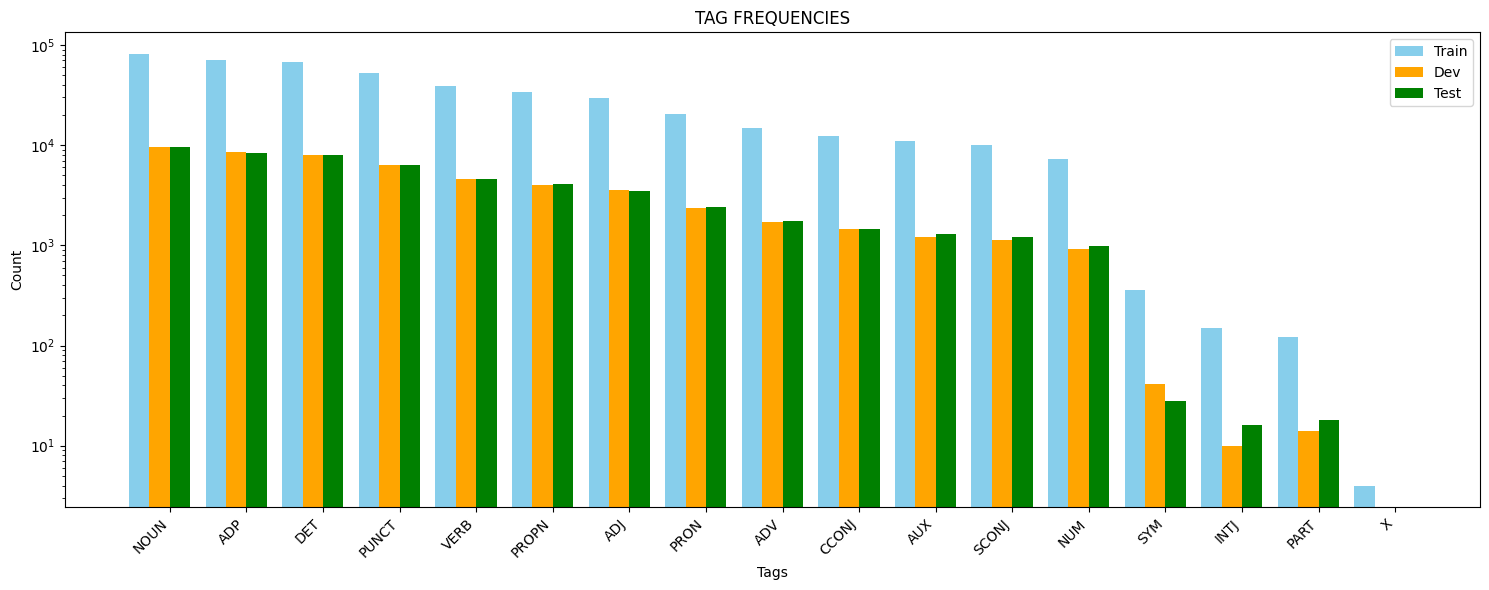

In [18]:
data = {'train' : counts_trains['Spanish']['tags'],
        'dev' : counts_dev['Spanish']['tags'],
        'test' : counts_test['Spanish']['tags']}
plot_subsets_comparison(data, "TAG FREQUENCIES")

**Unknown words analysis**

In the training set, we mark as unknown words those words that appear less than 2 times. The next plot shows the pos tags of the unknown words in the train set. The most common unknown words are tagged as NOUN, which is the most common tag in the train set. This is expected, as the nouns are the most probable words to appear only once or twice in the dataset, and also because the nouns are the most common words in the dataset. The tag VERB and ADJ appears also a lot of times as <UNK> in this case.

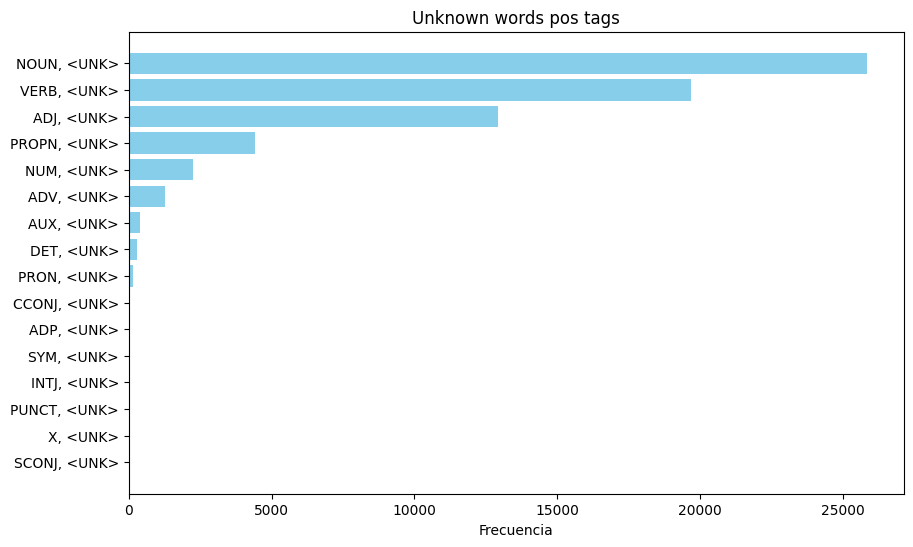

In [20]:
plot_pos_with_unknown(total_counts, "Unknown words pos tags", lang="Spanish")

### Result analysis

As in English, now we train the Spanish the model with the train and dev set. We get the predictions made by the model for the test in Spanish set, and then we use the predictions together with the test to get the accuracy.

In [13]:
lang = "Spanish"
ruta_archivo = f"output/test_{lang}_predictions.jsonl"

all_tags, all_predictions, errors = get_tags_predictions(ruta_archivo)

**Accuracy of the Spanish model**

In [14]:
accuracy = accuracy_score(all_tags, all_predictions)
accuracy

0.9240796687926597

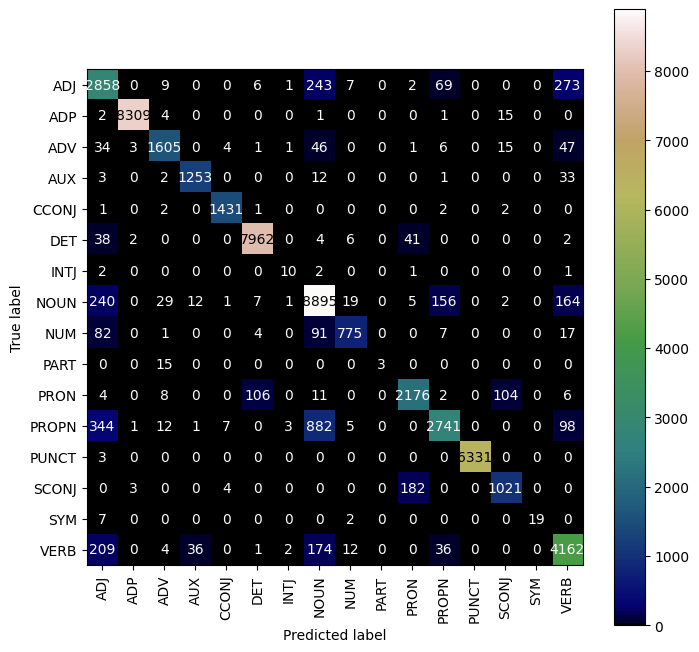

In [15]:
#create the confusion matrix
tags_set = sorted(set(all_tags))
cm = confusion_matrix(all_tags, all_predictions, labels=tags_set)

#show the plot
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust width and height as needed
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tags_set)
disp.plot(cmap="gist_earth", ax=ax, xticks_rotation="vertical")

plt.show()

As in English, the confusion matrix for Spanish shows that there is also high correlation between the predictions and the actual clases in Spanish. The accuracy is slightly higher than in English (0.92), even though the number of errors is higher, because there are much more sentences (and therefore, words and tags) in the Spanish dataset than in the English dataset. In this case, it is worth mentioning that the tags that the model confuses the most are the NOUN and PROPN. As the NOUN and PROPN are similar between them, this error is understandable. Also, the model makes a remarkable number of errors with the ADJ tag.

**FREQUENT INCORRECT WORDS ANALYSIS**

(Real Tag, Predicted Tag) [words frequency]


In [18]:
from collections import Counter
#print each type

for check_tag in ["ADJ", "NOUN", "VERB"]:
    print(f"-------{check_tag}--------")
    for tags,value in errors.items():
        if tags.split(",")[1] == check_tag:
            # Contar la cantidad de repeticiones de cada palabra
            word_counts = Counter(value)

            # Filtrar las palabras que aparecen más de una vez
            filtered_word_counts = {word: count for word, count in word_counts.items() if count > 1}

            # Ordenar las palabras por su frecuencia de mayor a menor
            sorted_filtered_word_counts = sorted(filtered_word_counts.items(), key=lambda x: x[1], reverse=True)
            if sorted_filtered_word_counts:
                print(tags, sorted_filtered_word_counts)
                print()

-------ADJ--------
NOUN,ADJ [('estadounidense', 10), ('pasado', 3), ('mínimo', 3), ('ciega', 3), ('éxitos', 2), ('francés', 2), ('sueco', 2), ('imputados', 2), ('gacela', 2), ('española', 2), ('ruso', 2), ('ciego', 2), ('multimedia', 2), ('caucus', 2), ('presente', 2), ('líneas', 2), ('vigilancia', 2), ('avioneta', 2), ('violador', 2), ('vestido', 2), ('diplomática', 2)]

PROPN,ADJ [('Nacional', 9), ('Mundiales', 6), ('Española', 6), ('Civil', 6), ('Internacional', 5), ('Social', 5), ('1C', 4), ('Mundial', 4), ('Maybach', 3), ('Abierto', 3), ('Mini', 3), ('Grandes', 3), ('Real', 3), ('Constitucional', 3), ('Catalana', 3), ('Unida', 2), ('Vasco', 2), ('Valencia', 2), ('Scud', 2), ('Davenport', 2), ('Superior', 2), ('Santamarta', 2), ('Mobil', 2), ('Calero', 2), ('Cardetti', 2), ('Agraria', 2), ('Municipal', 2), ('Humanos', 2), ('Olímpico', 2), ('Cambrils', 2), ('Crancs', 2), ('General', 2), ('Armadas', 2), ('Alto', 2), ('Atofina', 2), ('Ciudadano', 2)]

VERB,ADJ [('importa', 7), ('pasad

Adjective errors often involve confusion with nouns (NOUN), proper nouns (PROPN), and verbs (VERB). Words like "estadounidense" and "pasado" are frequently tagged as nouns, likely due to their common nominal use in some contexts. Proper nouns such as "Nacional" and "Internacional" are misclassified as adjectives, potentially because these terms are descriptive in nature but also serve as names in official titles.


Noun errors arise from confusion with proper nouns (PROPN), adjectives (ADJ), and auxiliary verbs (AUX). For example, proper nouns like "Gobierno" and "Rey" are labeled as nouns, which could result from the overlapping syntactic roles these words play in Spanish. Adjectives such as "profesionales" and breve are tagged as nouns, reflecting challenges in identifying whether the word functions as a descriptive term or a substantive in specific contexts. Additionally,  other tags like NUM, AUX or VERBS are incorrectly tagged due to they are not in the train dataset.

Verbs are often confused with nouns (NOUN), adjectives (ADJ), and auxiliary verbs (AUX). Nouns such as decir and cuenta are tagged as verbs, possibly because they appear in verbal contexts like idiomatic expressions or derived forms. Adjectives like elegido and convertido are mislabeled as verbs, highlighting difficulties in distinguishing between past participles functioning as adjectives and their verbal forms. Lastly, auxiliary verbs such as estar and saber are misclassified as main verbs, indicating a need for better disambiguation of auxiliary functions within the dataset.

### EXPERIMENT WITH THE LEMMAS

ACCURACY: 0.9359404721942486


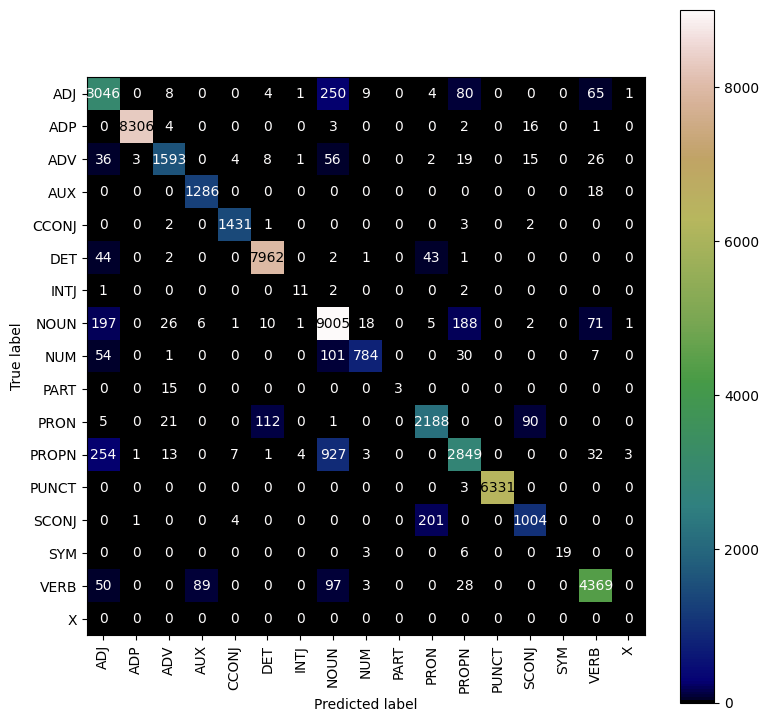

In [23]:
lang = "Spanish"
ruta_archivo = f"output/test_{lang}_predictions.jsonl"

all_tags, all_predictions, errors = get_tags_predictions(ruta_archivo)

accuracy = accuracy_score(all_tags, all_predictions)
print(f"ACCURACY: {accuracy}")

#create the confusion matrix
tags_set = sorted(set(all_predictions))
cm=confusion_matrix(all_tags, all_predictions, labels=tags_set)

#show the plot
fig, ax = plt.subplots(figsize=(9, 9))  # Adjust width and height as needed
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tags_set)
disp.plot(cmap="gist_earth", ax=ax, xticks_rotation="vertical")

plt.show()


After rerunning the train using lemmas instead of surface forms, the accuracy of the model improved slightly, increasing by 0.01. This minor improvement indicates that lemmatization helps the model generalize better by reducing the variability caused by different word inflections. While the change is small, it suggests that lemmatization can contribute to more precise tag predictions in certain contexts.

## OUT-OF-DOMAIN RESULTS

# ENGLISH

In [28]:
lang = "English"
ruta_archivo = f"output/od_{lang}_predictions.jsonl"

all_tags = []
all_predictions = []

# read de jsonl file and process it
with open(ruta_archivo, "r", encoding="utf-8") as archivo:
    contenido = archivo.read()
    contenido = "[" + contenido.strip().replace("}\n{", "},{") + "]"
    elementos = json.loads(contenido)
    #print(len(elementos[0]))

# get the tag and prediction of each instance and concatenate them
for elemento in elementos:
    if len(elemento.get("tags", [])) != len(elemento.get("prediction", [])):
        print(elemento.get("sentence"))
    all_tags.extend(elemento.get("tags", []))
    all_predictions.extend(elemento.get("prediction", []))

In [62]:
accuracy = accuracy_score(all_tags, all_predictions)
accuracy

0.5617824644952802

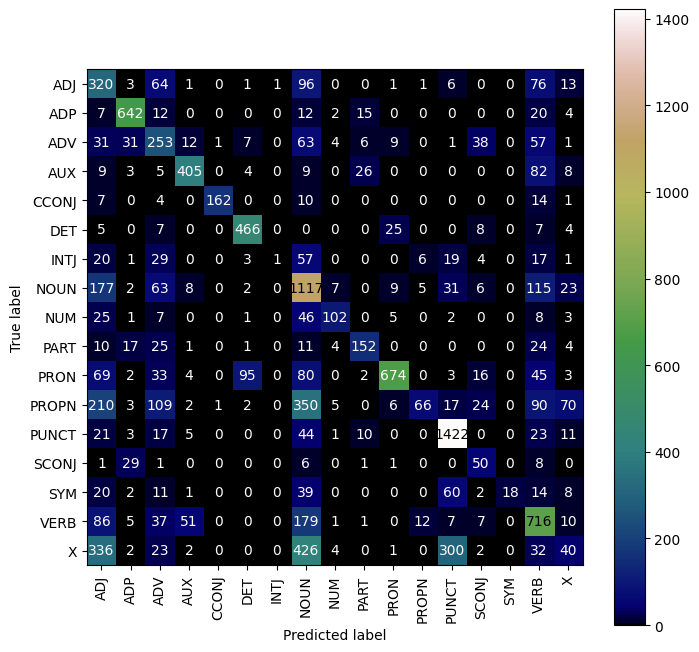

In [63]:
#create the confusion matrix
tags_set = sorted(set(all_tags))
cm = confusion_matrix(all_tags, all_predictions, labels=tags_set)
cm

#show the plot
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust width and height as needed
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tags_set)
disp.plot(cmap="gist_earth", ax=ax, xticks_rotation="vertical")

plt.show()

# Spanish

In [64]:
lang = "Spanish"
ruta_archivo = f"output/od_{lang}_predictions.jsonl"

all_tags = []
all_predictions = []

# read de jsonl file and process it
with open(ruta_archivo, "r", encoding="utf-8") as archivo:
    contenido = archivo.read()
    contenido = "[" + contenido.strip().replace("}\n{", "},{") + "]"
    elementos = json.loads(contenido)
    #print(len(elementos[0]))

# get the tag and prediction of each instance and concatenate them
for elemento in elementos:
    if len(elemento.get("tags", [])) != len(elemento.get("prediction", [])):
        print(elemento.get("sentence"))
    all_tags.extend(elemento.get("tags", []))
    all_predictions.extend(elemento.get("prediction", []))

In [65]:
accuracy = accuracy_score(all_tags, all_predictions)
accuracy

0.640244772309194

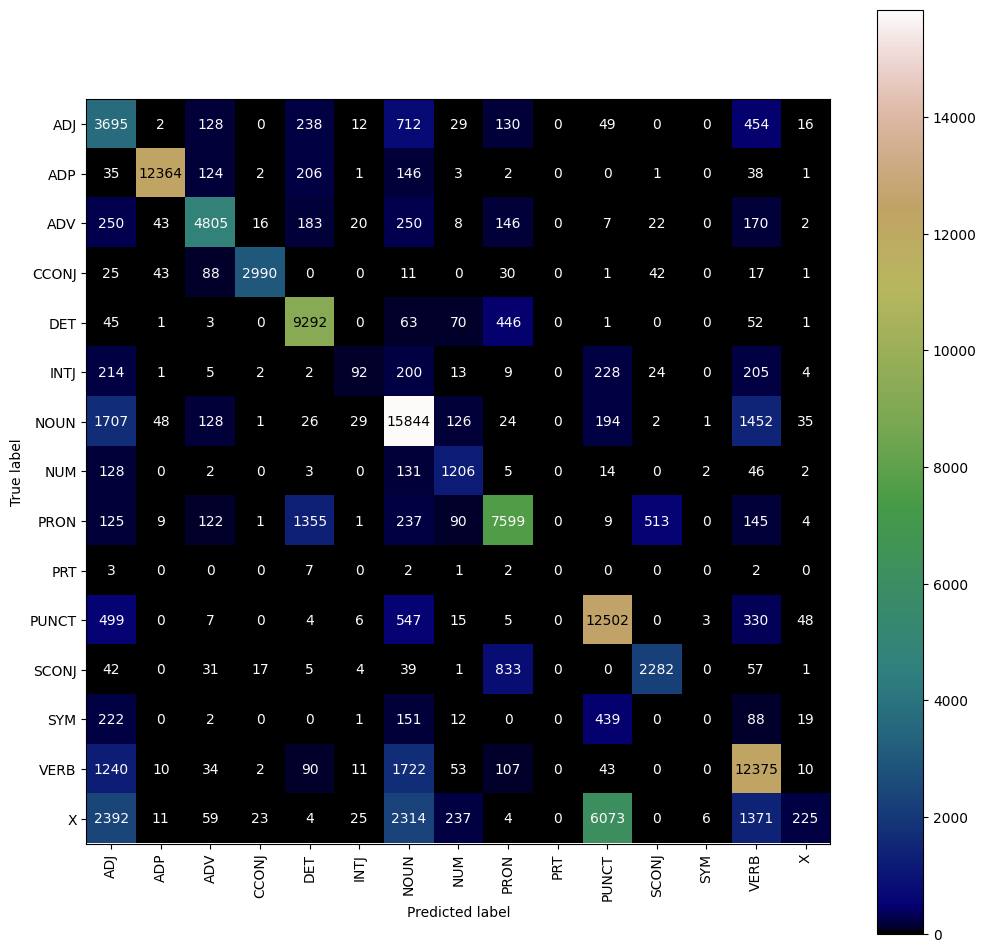

In [67]:
#create the confusion matrix
tags_set = sorted(set(all_tags))
cm = confusion_matrix(all_tags, all_predictions, labels=tags_set)
cm

#show the plot
fig, ax = plt.subplots(figsize=(12, 12))  # Adjust width and height as needed
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tags_set)
disp.plot(cmap="gist_earth", ax=ax, xticks_rotation="vertical")

plt.show()